# Generalization, similarity, and Bayesian inference

### First, some auxiliary functions and the notebook setup.

In [113]:
# -*- coding: utf-8 -*-
import matplotlib.pylab as plt
import numpy as np
import matplotlib
import operator
from matplotlib.pyplot import gca

% matplotlib inline

%load_ext autoreload
%autoreload 2

matplotlib.rcParams['figure.figsize'] = (15.0, 2.0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
def fact(x):
    if x == 0:
        return 1
    else:
        return fact(x-1) * x

def erlang(x, k, mu):
    l = 1.0/mu
    return ((l**k)*x**(k-1)*np.exp(-l*x)) / fact(k-1)

def product(iterable):
    return reduce(lambda x, rec: x*rec, iterable, 1)

def plot(y_range, samples_probs, X):
    title_string = "samples: {}".format(X)
    plt.title(title_string, size=14)

    plt.plot(y_range, [samples_probs[y] for y in y_range])
    plt.xlabel("y", size=20)
    plt.xticks(range(0, 100))
    plt.rc('text', usetex=True)
    plt.ylabel("$p(y \in C | x)$", size=20)
    if isinstance(X, list):
        xs = X
    else:
        xs = [X]
    plt.yticks([x/100.0 for x in range(0, 101, 20)])
    a = gca()
    a.set_xticklabels(a.get_xticks(), rotation="vertical")
    for i, xtick in enumerate(plt.gca().get_xticklabels()):
        xtick.set_alpha(min(1, samples_probs[i] + 0.3))

    plt.plot(xs, [0]*len(xs), 'o')
    plt.ylim([-0.1, 1.2])
    plt.xlim([-1, 100])
    plt.show()

def prime(x):
    return len([y for y in range(2, x) if x % y == 0]) == 0

In [79]:
def generate_consecuentials_intervals(X, max_hypothesis_size):
    ## Generates consecuential regions around a number x of sizes max_size as maximun.
    consecuential_regions = []

    hypotheses_sizes = range(0, max_hypothesis_size + 1)
    x = int(np.median(X))
        
    for size in hypotheses_sizes:
        for start in range(x - (size - 1) , x + 1):
            if start < 0 or start+size-1 > 100: 
                continue
            region = range(start, start+size)
            if isinstance(X, list) and any([x not in region for x in X]):
                continue
            consecuential_regions.append(region)
    return consecuential_regions

### Probabilities using one sample 

$$ p(y \in C | x) = \sum_{h:y\in h}{p(h|x)} $$

$$ p(h|x) = \frac{p(x|h)p(h)}{p(x)} = \frac{p(x|h)p(h)}{\sum_{h' \in H}{p(x|h')p(h')}} $$

Strong sampling: 
$$p(x|h) = \begin{cases} 
      \frac{1}{|h|} & \text{si } x \in \text{h} \\
      0 & \text{si no} \\
   \end{cases}
$$

$$p(h) = f_{erlang}(|h|; 2, 20)$$

$  f_{erlang}(x; k,\mu)={\lambda^k x^{k-1} e^{-\lambda x} \over (k-1)!}\quad\text{ para }x, \lambda \geq 0 \text{ donde } \mu = 1/\lambda$

### Probabilities using multiple samples

$$ X = \{x_1, \dots, x_n\} $$
$$p(X|h) = \begin{cases} 
      \frac{1}{|h|^n} & \text{si } x_1, \dots, x_n \in \text{h} \\
      0 & \text{si no} \\
   \end{cases}
$$

In [110]:
# p(h|X)
def prob_hyp_given_sample(h, X, H, prior):
    
    # p(X|h)
    # X could be a simple sample [x].
    def prob_sample_given_hyp(X, h):
        n = len(X)
        cond = all([x in h for x in X])
        if cond:
            den = ((len(h)*1.0)**n)
            return 1.0/den
        else:
            return 0
    
    # p(h)
    def prob_hyp(h):
        if prior == "erlang":
            return erlang(len(h), k=2.0, mu=10.0)
        elif prior == "uniform":
            return 1.0/len(H)
     
    # p(x)
    def prob_sample(X):
        return sum([prob_sample_given_hyp(X, h2) * prob_hyp(h2) for h2 in H])

    return (prob_sample_given_hyp(X, h) * prob_hyp(h)) / prob_sample(X)

In [98]:
def calculate_y_probs(X, max_hypothesis_size = 40, H_generator=None, prior="erlang", max_hypothesis_level=3):
    if H_generator == None:
        H = generate_consecuentials_intervals(X, max_hypothesis_size)
        
        # Generates default consecuential regions (intervals)
    else:
        # Generates H using a specific function (H_generator)
        H_augmented = H_generator()
        
        # Filter hypothesis by hypothesis level
        before_cleaning = len(H_augmented)
        H_augmented = [(name, h, level) for name, h, level in H_augmented if level <=  max_hypothesis_level]
        if before_cleaning != len(H_augmented):
            print "ereasing", before_cleaning - len(H_augmented), "hypothesis, level > max_hypothesis_level ({})".format(max_hypothesis_level)

        valid_hypothesis = [(name, h, level) for i, (name, h, level) in enumerate(H_augmented) if all([x in h for x in X])]

        print "hypothesis that contains all the samples: "
        print "\n".join(["(level: {}) {}".format(level, name) for (name, h, level) in valid_hypothesis])
        
        
        H = [h for name, h, level in H_augmented]
        
    y_range = range(0, 100) # y_range: 0..99
    samples_probs = {} # Dict used to store the p(y in C | x) for each y in y_range
    
    for y in y_range:
        prob_y_in_C_given_X = sum([prob_hyp_given_sample(h, X, H, prior) for h in H if y in h])
        samples_probs[y] = round(prob_y_in_C_given_X, 3)

    plot(y_range, samples_probs, X)


#### Using Erlang distribution in order to assign likelihoods to hypothesis

The following was created using the length of the hypothesis as a parameter in the Erlang distribution ($\mu$ = 10). We add a threhold in the lenghts of the hypotesis to be generated in order to accelerate the computation. This threshold should be greater than the difference between the minimun and the maximun sample so some hypothesis contain the hole range. 

The threshold was set on 40 by default but could be changed if necesary. 

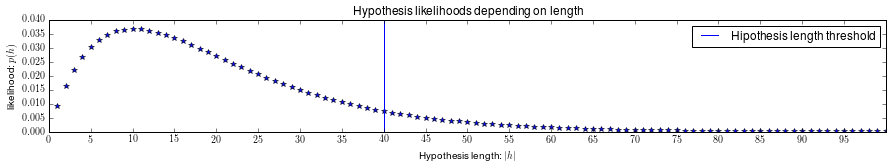

In [111]:
H = generate_consecuentials_intervals([60], 100)
hypothesis_probabilites = set([(len(h), erlang(len(h), k=2.0, mu=10.0)) for h in H])
plt.plot([hp[0] for hp in hypothesis_probabilites], [hp[1] for hp in hypothesis_probabilites], "*")
plt.axvline(x=40, label="Hipothesis length threshold")
plt.xticks(range(0,100, 5))
plt.title("Hypothesis likelihoods depending on length")
plt.xlabel("Hypothesis length: $|h|$")
plt.ylabel("likelihood: $p(h)$")
_ = plt.legend()


### Effect of the number of examples in Bayesian Generalization

(under the assumption of strong sampling and Erlang prior, $\mu$ = 10)

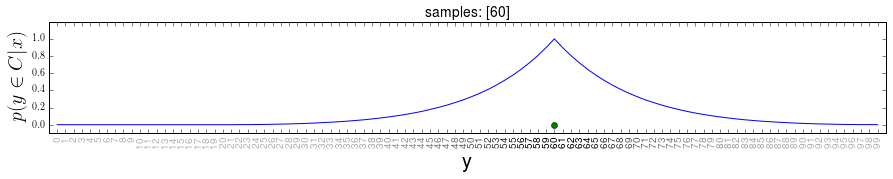

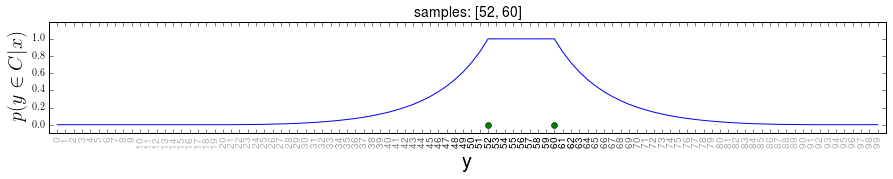

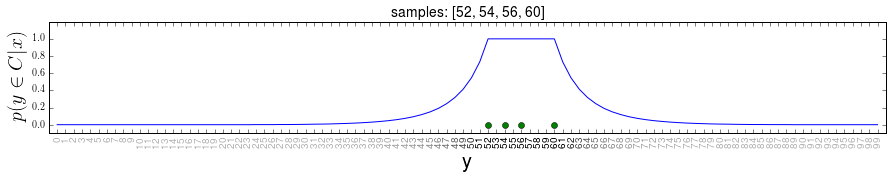

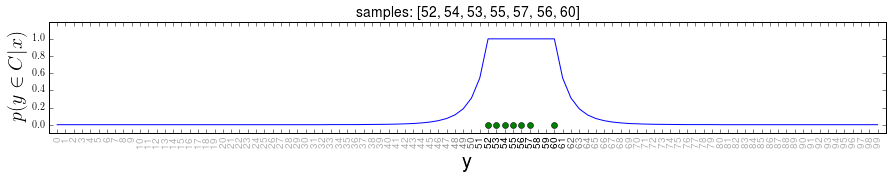

In [100]:
calculate_y_probs([60])
calculate_y_probs([52, 60])
calculate_y_probs([52, 54, 56, 60])
calculate_y_probs([52, 54, 53, 55, 57, 56, 60])

### Effect of example variability on Bayesian Generalization

(under the assumption of strong sampling and Erlang prior, $\mu$ = 10)

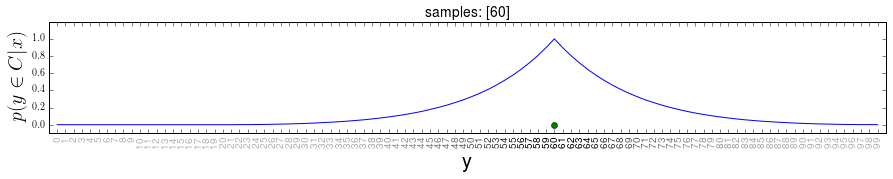

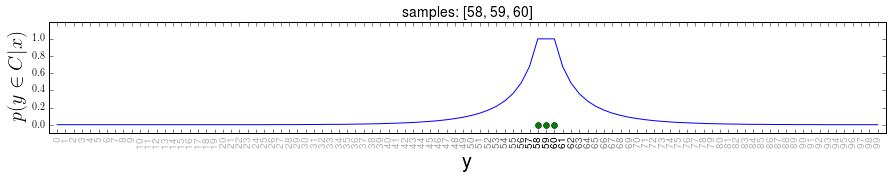

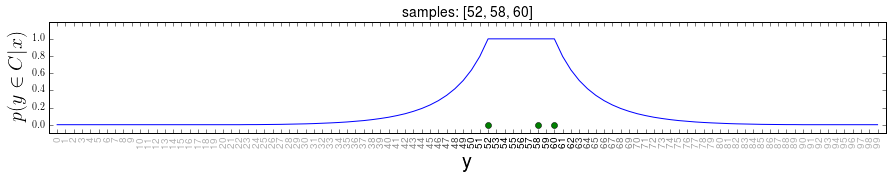

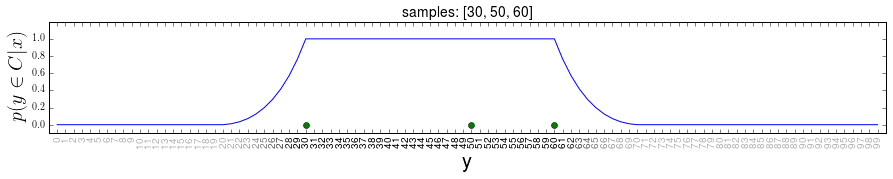

In [106]:
calculate_y_probs([60])
calculate_y_probs([58, 59, 60])
calculate_y_probs([52, 58, 60])
calculate_y_probs([30, 50, 60])

## Arbitrary stimulus structure

A hypothesis generator was built using 33 basic math properties:

In [112]:
import math
def filter_by(prop):
    return [x for x in range(1, 100) if prop(x)]

def math_properties_generator():
    odd = filter_by(lambda x: x % 2 == 1)
    primes = filter_by(lambda x: prime(x))
    perfect_squares = filter_by(lambda x: int(math.sqrt(x))**2 == x)
    perfect_cubes = filter_by(lambda x: int(round(x ** (1. / 3))) ** 3 == x)
    
    
    H_augmented = [("odd", odd, 1), 
         ("primes", primes, 3), 
         ("perfect squares", perfect_squares, 3), 
         ("perfect cubes", perfect_cubes, 3)]
    
    
    for n in range(2,11):
        multiples_of = filter_by(lambda x: x % n == 0)
        H_augmented.append(("mutiples of {}".format(n), multiples_of, 1))
    
    for n in range(2,11):
        powers_of = filter_by(lambda x: int(math.log(x, n)) == math.log(x, n))
        H_augmented.append(("powers of {}".format(n), powers_of, 2))
        
    for n in range(1,10):
        numbers_ending_with = filter_by(lambda x: x % 10 == n)
        H_augmented.append(("numbers ending with {}".format(n), numbers_ending_with, 1))
        
    same_digit = filter_by(lambda x: x%10 == (x/10)%10)
    H_augmented.append(("same digit", same_digit, 1))
    
    all_numbers = filter_by(lambda x: True)
    H_augmented.append(("All numbers < 100", all_numbers, 1))
    
    return H_augmented

math_properties = math_properties_generator()
print "generated properties: \n", "\n".join(["{}. {}".format(i+1, m[0]) for i,m in enumerate(math_properties)])

generated properties: 
1. odd
2. primes
3. perfect squares
4. perfect cubes
5. mutiples of 2
6. mutiples of 3
7. mutiples of 4
8. mutiples of 5
9. mutiples of 6
10. mutiples of 7
11. mutiples of 8
12. mutiples of 9
13. mutiples of 10
14. powers of 2
15. powers of 3
16. powers of 4
17. powers of 5
18. powers of 6
19. powers of 7
20. powers of 8
21. powers of 9
22. powers of 10
23. numbers ending with 1
24. numbers ending with 2
25. numbers ending with 3
26. numbers ending with 4
27. numbers ending with 5
28. numbers ending with 6
29. numbers ending with 7
30. numbers ending with 8
31. numbers ending with 9
32. same digit
33. All numbers < 100


### Effect of samples on math hypothesis sets

hypothesis that contains all the samples: 
(level: 1) mutiples of 2
(level: 1) mutiples of 3
(level: 1) mutiples of 4
(level: 1) mutiples of 5
(level: 1) mutiples of 6
(level: 1) mutiples of 10
(level: 1) All numbers < 100


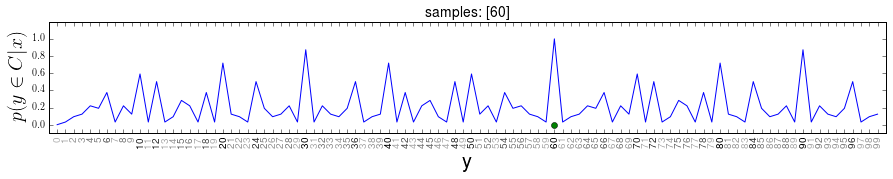

hypothesis that contains all the samples: 
(level: 1) mutiples of 2
(level: 2) powers of 2
(level: 1) All numbers < 100


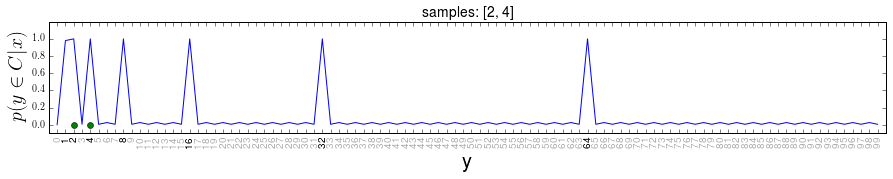

hypothesis that contains all the samples: 
(level: 1) mutiples of 2
(level: 1) numbers ending with 2
(level: 1) same digit
(level: 1) All numbers < 100


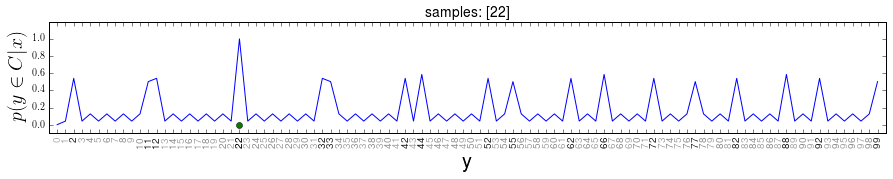

In [103]:
calculate_y_probs([60], H_generator=math_properties_generator, prior="uniform")
calculate_y_probs([2, 4], H_generator=math_properties_generator, prior="uniform")
calculate_y_probs([22], H_generator=math_properties_generator, prior="uniform")

ereasing 12 hypothesis, level > max_hypothesis_level (1)
hypothesis that contains all the samples: 
(level: 1) mutiples of 2
(level: 1) All numbers < 100


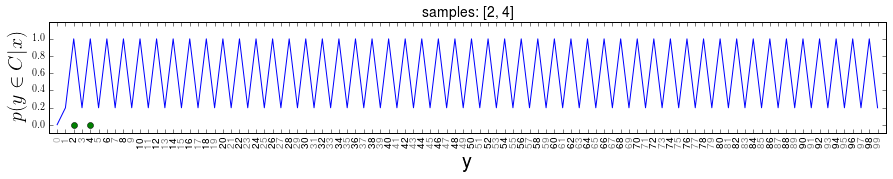

ereasing 3 hypothesis, level > max_hypothesis_level (2)
hypothesis that contains all the samples: 
(level: 1) mutiples of 2
(level: 2) powers of 2
(level: 1) All numbers < 100


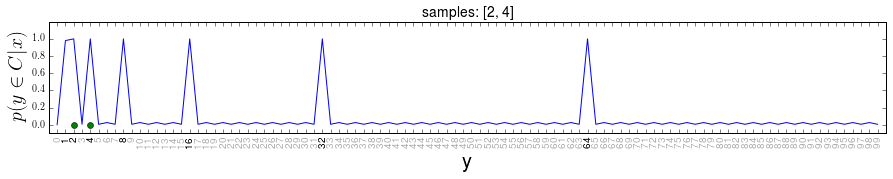

hypothesis that contains all the samples: 
(level: 1) mutiples of 2
(level: 2) powers of 2
(level: 1) All numbers < 100


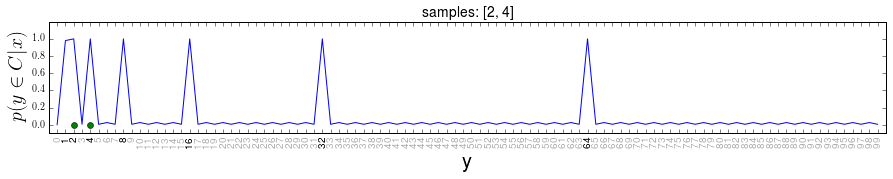

In [104]:
calculate_y_probs([2, 4], H_generator=math_properties_generator, prior="uniform", max_hypothesis_level=1)
calculate_y_probs([2, 4], H_generator=math_properties_generator, prior="uniform", max_hypothesis_level=2)
calculate_y_probs([2, 4], H_generator=math_properties_generator, prior="uniform", max_hypothesis_level=3)

### Effect of constrains on Hypothesis Levels

We see now how adding thresholds for the hypothesis the model can use changes the new samples probabilities.

ereasing 12 hypothesis, level > max_hypothesis_level (1)
hypothesis that contains all the samples: 
(level: 1) odd
(level: 1) mutiples of 3
(level: 1) mutiples of 9
(level: 1) numbers ending with 1
(level: 1) All numbers < 100


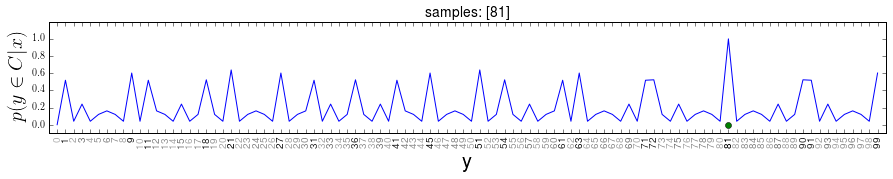

ereasing 3 hypothesis, level > max_hypothesis_level (2)
hypothesis that contains all the samples: 
(level: 1) odd
(level: 1) mutiples of 3
(level: 1) mutiples of 9
(level: 2) powers of 3
(level: 2) powers of 9
(level: 1) numbers ending with 1
(level: 1) All numbers < 100


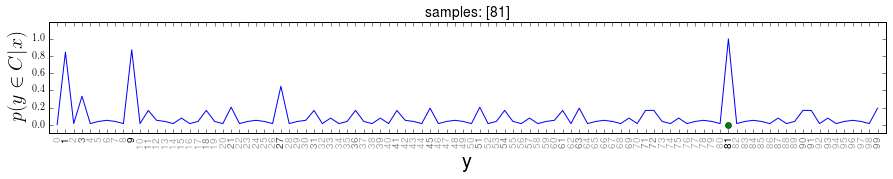

hypothesis that contains all the samples: 
(level: 1) odd
(level: 3) perfect squares
(level: 1) mutiples of 3
(level: 1) mutiples of 9
(level: 2) powers of 3
(level: 2) powers of 9
(level: 1) numbers ending with 1
(level: 1) All numbers < 100


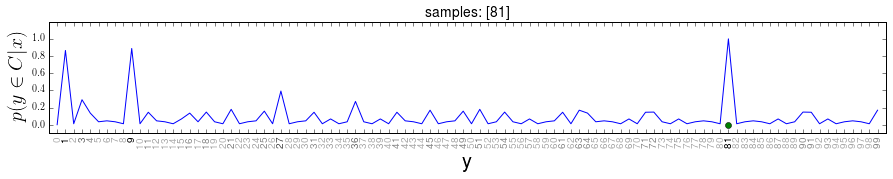

In [105]:
calculate_y_probs([81], H_generator=math_properties_generator, prior="uniform", max_hypothesis_level=1)
calculate_y_probs([81], H_generator=math_properties_generator, prior="uniform", max_hypothesis_level=2)
calculate_y_probs([81], H_generator=math_properties_generator, prior="uniform", max_hypothesis_level=3)